# Graph Training Sandbox

In [1]:
# System imports
import os
import sys
from pprint import pprint as pp
from time import time as tt

# External imports
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.data import DataLoader

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# Limit CPU usage on Jupyter
os.environ['OMP_NUM_THREADS'] = '4'

# Pick up local packages
sys.path.append('..')

# Local imports
from toy_utils import *
%matplotlib widget

## Generate hits

Generate circles

In [2]:
# Circle parameters
num_layers = 10
height, width = 10, 10
min_curve, max_curve = 15, 50
noise = False
event_size_min, event_size_max = 4, 12 #I.E. The number of true particle tracks
max_angle=(4/6)*np.pi

## Assign Edges, PIDs, Layer Number & Shuffle

### PIDs and Layer Numbers

### Make Edges

Choose maximum angle

In [3]:
event = gen_graph_class(event_size_min, event_size_max, max_curve, min_curve, height, num_layers, max_angle)

tensor([4])
0.22214007377624512


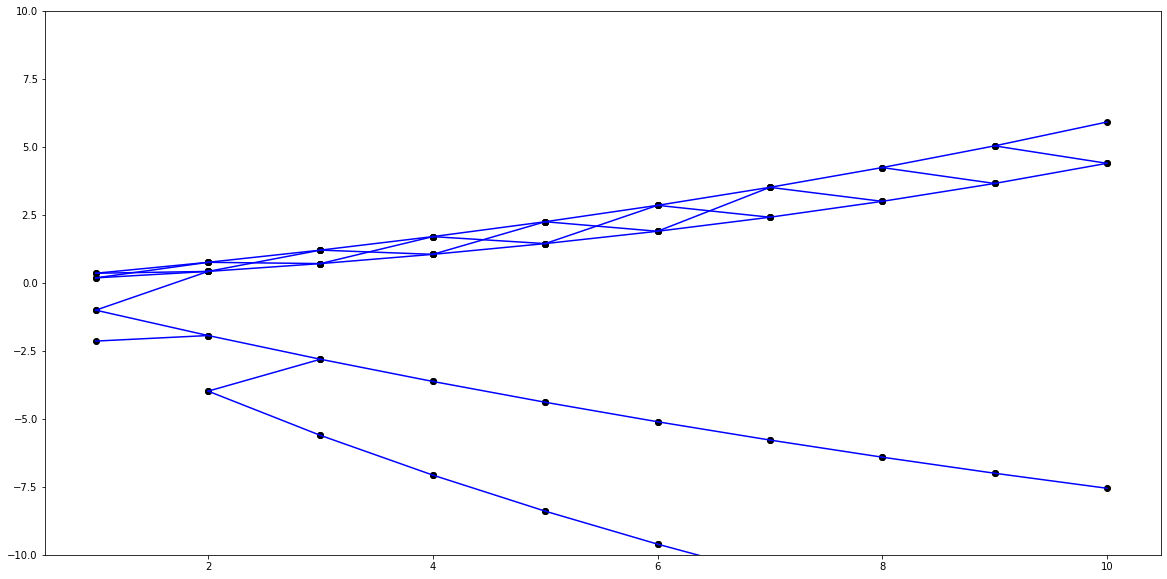

In [4]:
tic = tt()
plt.figure(figsize=(20,10))
X = event.x
e = event.edge_index
y = event.y
print(y)
for i, j in zip(X[e[0]], X[e[1]]):
    plt.plot([i[0], j[0]], [i[1], j[1]], c='b')
#     print(i[0], i[2], j[0], j[2])
    plt.scatter(i[0], i[1], c='k')
    plt.scatter(j[0], j[1], c='k')
plt.ylim(-10,10)
print(tt() - tic)

## Interactive Version of Above

(For fun...)

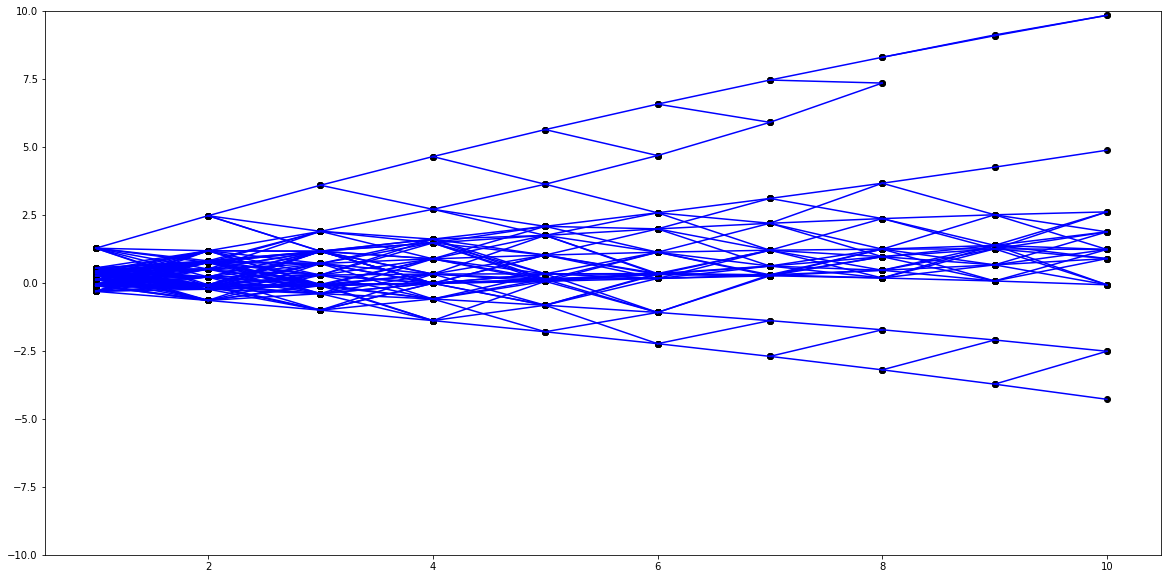

In [3]:
@interact
def gen_plot_event(maximum_of_curve = max_curve, maximum_angle_cutoff = (np.pi/4,np.pi)): 
    event = gen_graph_class(event_size_min, event_size_max, maximum_of_curve, min_curve, height, num_layers, maximum_angle_cutoff)
    plt.figure(figsize=(20,10))
    X = event.x
    e = event.edge_index
    y = event.y
    for i, j in zip(X[e[0]], X[e[1]]):
        plt.plot([i[0], j[0]], [i[1], j[1]], c='b')
    #     print(i[0], i[2], j[0], j[2])
        plt.scatter(i[0], i[1], c='k')
        plt.scatter(j[0], j[1], c='k')
    plt.ylim(-10,10)

## Constructing PyG Datastructure

In [11]:
train_dataset = [gen_graph_class(event_size_min, event_size_max, max_curve, min_curve, height, num_layers, max_angle) for i in range(1000)]
test_dataset = [gen_graph_class(event_size_min, event_size_max, max_curve, min_curve, height, num_layers, max_angle) for i in range(500)]

KeyboardInterrupt: 

In [6]:
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using ", device)
# model = Edge_Class_Net( input_dim=2, hidden_dim=64, n_graph_iters=4).to(device)
model = Net(train_dataset).to(device)
# data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=1e-3)

Using  cuda


## Edge Classification Testing

In [51]:
model.train()
loss_v = []
acc_v = []
ep = 0
for epoch in range(500):
    ep += 1
    correct = 0
    total = 0
    for batch in train_loader:
#         print(batch.x)
        optimizer.zero_grad()
        data = batch.to(device)
        pred = model(data)
        loss = F.binary_cross_entropy_with_logits(pred.float(), data.y.float())
        loss.backward()
        optimizer.step()
        correct += ((pred > 0.5) == (data.y > 0.5)).sum().item()
#         print(correct, pred, data.y)
        total += len(pred)
#         print(out, data.y, )
    acc = correct/total
    print("Epoch: " , ep, ", loss: ", loss.item(), ", accuracy: ", acc)
    loss_v.append(loss)
    acc_v.append(acc)
plt.plot(np.arange(len(loss_v)), loss_v)
plt.plot(np.arange(len(acc_v)), acc_v)
plt.ylim(0.1,1)

Epoch:  1 , loss:  0.5512356758117676 , accuracy:  0.6864395625058761
Epoch:  2 , loss:  0.5046652555465698 , accuracy:  0.7436710645899276
Epoch:  3 , loss:  0.48637688159942627 , accuracy:  0.7629634272462315
Epoch:  4 , loss:  0.47630026936531067 , accuracy:  0.7705349587890564
Epoch:  5 , loss:  0.4798726439476013 , accuracy:  0.7736814064997336
Epoch:  6 , loss:  0.4695682227611542 , accuracy:  0.7731611770973706
Epoch:  7 , loss:  0.4612908959388733 , accuracy:  0.7738506377511047
Epoch:  8 , loss:  0.44322115182876587 , accuracy:  0.7768779968034097
Epoch:  9 , loss:  0.46184107661247253 , accuracy:  0.7758438058228087
Epoch:  10 , loss:  0.43595728278160095 , accuracy:  0.7730358206148735
Epoch:  11 , loss:  0.40324726700782776 , accuracy:  0.7812466702184336
Epoch:  12 , loss:  0.3373474180698395 , accuracy:  0.7961014133943402
Epoch:  13 , loss:  0.27982667088508606 , accuracy:  0.8321476699363816
Epoch:  14 , loss:  0.2253979742527008 , accuracy:  0.8571813594910527
Epoch:  

KeyboardInterrupt: 

In [52]:
model.eval()
for batch in test_loader:
    print(batch)
    data = batch.to(device)
    pred = model(data)
    correct = ((pred > 0.5) == (data.y > 0.5)).sum().item()
    acc = correct / len(pred)
    print('Accuracy: {:.4f}'.format(acc))

Batch(batch=[5930], edge_index=[2, 14580], x=[5930, 2], y=[14580])
Accuracy: 0.9812
Batch(batch=[5880], edge_index=[2, 14637], x=[5880, 2], y=[14637])
Accuracy: 0.9832
Batch(batch=[5580], edge_index=[2, 14190], x=[5580, 2], y=[14190])
Accuracy: 0.9862
Batch(batch=[5710], edge_index=[2, 14652], x=[5710, 2], y=[14652])
Accuracy: 0.9838
Batch(batch=[5470], edge_index=[2, 12952], x=[5470, 2], y=[12952])
Accuracy: 0.9866


## Track Count Testing


In [9]:
train_dataset = [gen_graph_class(event_size_min, event_size_max, max_curve, min_curve, height, num_layers, max_angle) for i in range(1000)]
test_dataset = [gen_graph_class(event_size_min, event_size_max, max_curve, min_curve, height, num_layers, max_angle) for i in range(500)]

In [10]:
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using ", device)
# model = Edge_Class_Net( input_dim=2, hidden_dim=64, n_graph_iters=4).to(device)
model = Net(train_dataset).to(device)
# data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

Using  cuda


In [12]:
model.train()
loss_v = []
acc_v = []
ep = 0
for epoch in range(500):
    ep += 1
    correct = 0
    total = 0
    for batch in train_loader:
#         print(batch.x)
        optimizer.zero_grad()
        data = batch.to(device)
        out = model(data)
        _, pred = out.max(dim=1)
        print(pred.shape, data.y.shape, pred, data.y)
        loss = F.cross_entropy(out, data.y)
        loss.backward()
        optimizer.step()
        
        correct += float(pred.eq(data.y).sum().item())
#         print(correct, pred, data.y)
        total += len(pred)
#         print(out, data.y, )
    acc = correct/total
    print("Epoch: " , ep, ", loss: ", loss.item(), ", accuracy: ", acc)
    loss_v.append(loss)
    acc_v.append(acc)
plt.plot(np.arange(len(loss_v)), loss_v)
plt.plot(np.arange(len(acc_v)), acc_v)
plt.ylim(0.1,1)

torch.Size([100]) torch.Size([100]) tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6], device='cuda:0') tensor([ 9,  9,  7,  4,  7,  3,  5,  7,  6,  7,  4,  7,  2,  6,  5,  6,  7,  9,
         5,  9,  6,  9,  5,  7,  8,  8,  4,  4,  7,  5,  6,  4,  4,  8, 10,  1,
         5,  8,  8,  5,  8,  4,  9,  5,  9,  6,  2,  9,  5,  4,  7,  4,  9,  5,
         9,  5,  5,  4,  9,  6,  5,  7,  6,  4,  7,  4, 11,  4, 11,  5,  7,  4,
         7,  7,  9,  5,  3,  7,  3,  6,  3,  8,  3,  6,  6,  4,  6,  4,  8,  3,
         7,  7,  8,  2,  6,  6,  3,  4,  8,  2], device='cuda:0')
torch.Size([100]) torch.Size([100]) tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6

KeyboardInterrupt: 

In [23]:
model.eval()
for batch in test_loader:
    print(batch)
    data = batch.to(device)
    _, pred = model(data).max(dim=1)
    print(pred, data.y)
    correct = float(pred.eq(data.y).sum().item())
    acc = correct / len(pred)
    print('Accuracy: {:.4f}'.format(acc))

Batch(batch=[6110], edge_index=[2, 16297], x=[6110, 2], y=[100])
tensor([ 7,  7,  7,  4,  6,  4,  6,  9,  7,  9,  8,  2,  5,  6,  5,  6,  7,  7,
         9,  7,  4,  7,  9,  9,  5,  8,  5,  5,  4,  9,  7,  4,  9,  3,  9,  4,
         6,  5,  4,  6,  4,  7,  3,  5,  5,  4,  5,  5, 10,  5,  2,  7,  9,  6,
        10,  4,  3,  9,  4,  9,  4,  8,  6,  9,  9,  5,  1,  9,  7,  9,  5,  4,
         9,  6,  4,  9,  4,  4,  3,  7,  7,  9,  4,  4,  3,  7,  7,  4,  6,  9,
         7,  9, 10,  7,  9,  4, 10,  5,  7,  6], device='cuda:0') tensor([ 7,  7,  8,  4,  6,  4,  5, 11,  8, 10,  8,  3,  5,  6,  4,  6,  7,  6,
         8,  7,  4,  7,  9,  8,  5,  8,  5,  5,  2, 10,  7,  5,  9,  2,  8,  4,
         6,  5,  4,  6,  4,  7,  3,  5,  6,  5,  5,  6, 10,  5,  2,  6,  7,  6,
        11,  4,  3,  9,  3,  9,  4,  8,  6,  8,  6,  6,  2,  8,  7,  8,  5,  4,
         6,  5,  3,  9,  4,  3,  3,  6,  8, 10,  5,  4,  3,  7,  9,  4,  6,  5,
         7,  9,  9,  7, 10,  4, 11,  5,  6,  6], device='cuda:0')
Acc

## Combined Counter & Classifier

In [3]:
train_dataset = [gen_edge_graph_class(event_size_min, event_size_max, max_curve, min_curve, height, num_layers, max_angle) for i in range(1000)]
test_dataset = [gen_edge_graph_class(event_size_min, event_size_max, max_curve, min_curve, height, num_layers, max_angle) for i in range(500)]

/global/u2/d/danieltm/ExaTrkX/eta-tracker/notebooks/toy_utils.py:32: RuntimeWarning: invalid value encountered in sqrt
  return sign*np.sqrt(r**2 - a**2) + np.sqrt(r**2 - (x-a)**2)
/global/u2/d/danieltm/ExaTrkX/eta-tracker/notebooks/toy_utils.py:34: RuntimeWarning: invalid value encountered in sqrt
  return sign*np.sqrt(r**2 - a**2) - np.sqrt(r**2 - (x-a)**2)


In [4]:
train_dataset[0].y_graph.item()

4

In [5]:
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using ", device)
# model = Edge_Class_Net( input_dim=2, hidden_dim=64, n_graph_iters=4).to(device)
model = Edge_Graph_Class_Net(input_dim=2, hidden_dim=16, n_graph_iters=4, output_dim=12).to(device)
# data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

Using  cuda


In [23]:
model.train()
loss_v = []
acc_v_count = []
acc_v_edge = []
ep = 0
for epoch in range(500):
    ep += 1
    count_correct = 0
    edge_correct = 0
    count_total = 0
    edge_total = 0 
    for batch in train_loader:
#         print(batch.x)
        optimizer.zero_grad()
        data = batch.to(device)
        edge_pred, graph_pred = model(data)
        _, graph_pred_max = graph_pred.max(dim=1)
        losses = [F.binary_cross_entropy_with_logits(edge_pred.float(), data.y.float()), F.cross_entropy(graph_pred, data.y_graph)]
#         print(losses[0].item(), losses[1].item())
        loss = sum(losses)
        loss.backward()
        optimizer.step()

        edge_correct += ((edge_pred > 0.5) == (data.y > 0.5)).sum().item()
        count_correct += float(graph_pred_max.eq(data.y_graph).sum().item())
#         print(correct, pred, data.y)
        count_total += len(graph_pred_max)
        edge_total += len(edge_pred)
#         print(out, data.y, )
    count_acc = count_correct/count_total
    edge_acc = edge_correct / edge_total
    print("Epoch: " , ep, ", loss: ", loss.item(), ", count accuracy: ", count_acc, ", edge accuracy: ", edge_acc)
    loss_v.append(loss)
    acc_v_count.append(count_acc)
    acc_v_edge.append(edge_acc)
plt.plot(np.arange(len(loss_v)), loss_v)
plt.plot(np.arange(len(acc_v_count)), acc_v_count)
plt.plot(np.arange(len(acc_v_edge)), acc_v_edge)
plt.ylim(0.1,1)

Epoch:  1 , loss:  3.1576285362243652 , count accuracy:  0.122 , edge accuracy:  0.6513064133016627
Epoch:  2 , loss:  3.1742045879364014 , count accuracy:  0.134 , edge accuracy:  0.6614945111382166
Epoch:  3 , loss:  3.0324511528015137 , count accuracy:  0.134 , edge accuracy:  0.6614945111382166
Epoch:  4 , loss:  3.011707305908203 , count accuracy:  0.158 , edge accuracy:  0.6614945111382166
Epoch:  5 , loss:  3.0208494663238525 , count accuracy:  0.196 , edge accuracy:  0.6620851255055531
Epoch:  6 , loss:  3.003718137741089 , count accuracy:  0.182 , edge accuracy:  0.6734865506837003
Epoch:  7 , loss:  2.8945674896240234 , count accuracy:  0.193 , edge accuracy:  0.6919881877126532
Epoch:  8 , loss:  2.9283816814422607 , count accuracy:  0.194 , edge accuracy:  0.7084547730628491
Epoch:  9 , loss:  2.8948309421539307 , count accuracy:  0.204 , edge accuracy:  0.7297875072221865
Epoch:  10 , loss:  2.914076328277588 , count accuracy:  0.208 , edge accuracy:  0.746857546382487
Epo

KeyboardInterrupt: 

In [11]:
model.eval()
for batch in test_loader:
    print(batch)
    data = batch.to(device)
    edge_pred, graph_pred = model(data)
    _, graph_pred_max = graph_pred.max(dim=1)
    correct = float(graph_pred_max.eq(data.y_graph).sum().item())
    acc = correct / len(graph_pred_max)
    print('Accuracy: {:.4f}'.format(acc))

Batch(batch=[5910], edge_index=[2, 14768], x=[5910, 2], y=[14768], y_graph=[100])
Accuracy: 0.6900
Batch(batch=[6130], edge_index=[2, 15735], x=[6130, 2], y=[15735], y_graph=[100])
Accuracy: 0.7000
Batch(batch=[6460], edge_index=[2, 17175], x=[6460, 2], y=[17175], y_graph=[100])
Accuracy: 0.6700
Batch(batch=[6180], edge_index=[2, 15944], x=[6180, 2], y=[15944], y_graph=[100])
Accuracy: 0.6800
Batch(batch=[6110], edge_index=[2, 15557], x=[6110, 2], y=[15557], y_graph=[100])
Accuracy: 0.8600


In [65]:
dir(tnn)

['AGNNConv',
 'APPNP',
 'ARGA',
 'ARGVA',
 'ARMAConv',
 'ChebConv',
 'DNAConv',
 'DataParallel',
 'DeepGraphInfomax',
 'DenseGCNConv',
 'DenseGINConv',
 'DenseSAGEConv',
 'DynamicEdgeConv',
 'ECConv',
 'EdgeConv',
 'FeaStConv',
 'GAE',
 'GATConv',
 'GCNConv',
 'GINConv',
 'GMMConv',
 'GatedGraphConv',
 'GlobalAttention',
 'GraphConv',
 'HypergraphConv',
 'InnerProductDecoder',
 'JumpingKnowledge',
 'MessagePassing',
 'MetaLayer',
 'NNConv',
 'PPFConv',
 'PointConv',
 'RENet',
 'RGCNConv',
 'Reshape',
 'SAGEConv',
 'SAGPooling',
 'SGConv',
 'Set2Set',
 'SignedConv',
 'SignedGCN',
 'SplineConv',
 'TopKPooling',
 'VGAE',
 'XConv',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'avg_pool',
 'avg_pool_x',
 'conv',
 'data_parallel',
 'dense',
 'dense_diff_pool',
 'fps',
 'glob',
 'global_add_pool',
 'global_max_pool',
 'global_mean_pool',
 'global_sort_pool',
 'graclus',
 'inits',
 'knn',
 'knn_graph